# Accurately Modeling Cross-Talk (pass only)

The purpose of this notebook is to provide an example of how a custom pass could model cross-talk noise between qubits in a circuit.

It tests the cross talk pass by showing what happens with extended delays applied in between hadamards.  The pass passes the test, as can be seen below.

First, we need to figure out when different qubits are in parallel delays.

In [1]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit import QuantumRegister
from qiskit.circuit import Delay
from qiskit.circuit.library import RZZGate, CXGate, RZGate
from pprint import pprint


# DEBUG = True
# VERBOSE = True
#Cross talk delay pass
class CrossTalkDelayReplace(TransformationPass):
    """Adds cross-talk delay error information to circuit metadata for noise model post processing"""

    def __init__(self, coupling_map, theta=0.1):
        """CrossTalk initializer
        Args:
            coupling_map (list(list(int)) or None): Coupling map for provided backend.  If None, pass will
                  not run
            theta: a default theta value to use since we can't define it yet for the cross talk.
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.theta = 0 if theta is None else theta
    
    def initQubitMapping(self, dag):
        """Initialize the qubit mapping to index and provide convenient
            variables for current time, if the previous op was a delay, and
            what the previous op's duration was.  For use when iterating over
            the DAG.

        Args:
            dag (DAGCircuit): the DAG to be optimized
            
        Returns:
            mapping of qubit to index and other loop variables (described above)
        """
        #if there's a coupling map when transpiled, it flattens all other registers
        #####dag.qubits <- the order of this list is the order in the coupling map
        return {qubit: {"idx": i,
                        "currTime": 0,
                        "prevOpDelay": False,
                        "prevOpDuration": 0,
                       }
                for i, qubit in enumerate(dag.qubits)}
    
    def splitDelay(self, startTime, duration, pivotTimes):
        """Splits a delay based on 'pivotTimes' array.

        Args:
            startTime  (int)      : delay start time
            duration   (int)      : delay duration
            pivotTimes (List(int)): list of times to split on
            
        Returns:
            dag (DAGCircuit): the list of new delays to replace the old one
        """
        endTime = startTime + duration
        
        #split and do stuff based on start and end times
        newCircuit = DAGCircuit()
        reg = QuantumRegister(1)
        newCircuit.add_qreg(reg)
        
        #need to split at every array element of pivotTimes in between startTime and endTime
        lastTime = startTime
#         if DEBUG and VERBOSE: newTimes = []
        for time in pivotTimes:
            #need to not add delay of length 0 (startTime <)
            # but need to include the last delay until the end time (<= endTime)
            if startTime < time <= endTime:
                #split
                newCircuit.apply_operation_back(Delay(duration=time-lastTime), [reg[0]], [])
#                 if DEBUG and VERBOSE: newTimes.append(time-lastTime)
                lastTime = time
        
#         if DEBUG and VERBOSE: print("Split delay(", startTime, ", ", endTime, ") (duration=", duration, ") into: ", newTimes)
        return newCircuit
    
    def getDelayPivotTimes(self, dag):
        """Gets all delay start and end times for the given circuit

        Args:
            dag (DAGCircuit): the dag to extract start and end times from
            
        Returns:
            List(int): list of all delay start and end times
        """
        ##reset qubit_mapping params
        qubit_mapping = self.initQubitMapping(dag)
        startTimes = []
        endTimes = []

        #iterate and extract times
        ##this relies on the assumption that each node returned by topological_op_nodes is
        ## in natural time order per qubit (not overall, only within each qubit)
        for node in dag.topological_op_nodes():
            op = node.op
            qubits = node.qargs
            duration = op.duration
            
            for qubit in qubits:
                #check op type
                if isinstance(op, Delay):
                    # if prev command wasn't a delay, add new delay start time
                    if not qubit_mapping[qubit]["prevOpDelay"]:
                        qubit_mapping[qubit]["prevOpDelay"] = True
                        startTimes.append(qubit_mapping[qubit]["currTime"])

                else:
                    #if prev command was a delay, this signifies the end of a delay
                    if qubit_mapping[qubit]["prevOpDelay"]:
                        #append end time to list
                        endTimes.append(qubit_mapping[qubit]["currTime"])
                    qubit_mapping[qubit]["prevOpDelay"] = False


                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += duration
                qubit_mapping[qubit]["prevOpDuration"] = duration

        #handle if it's the last delay/op for the qubit
        for qubit, data in qubit_mapping.items():
            if data["prevOpDelay"]:
                #add end time to list
                endTimes.append(data["currTime"])

        #any time a delay starts or ends, that is a significant event
        return sorted(set(startTimes + endTimes))
    
    def createNewCircuitWithDelays(self, dag, pivotTimes):
        """Creates a new circuit with all delays split on every "pivot" time

        Args:
            dag (DAGCircuit)      : the dag to split delay times on
            pivotTimes (list(int)): list of start and end times of all delays
            
        Returns:
            DAGCircuit: circuit with all delays split on every pivot time
        """
        ##reset qubit_mapping params
        qubit_mapping = self.initQubitMapping(dag)

        split_delay_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            split_delay_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            split_delay_dag.add_creg(creg)

        for node in dag.topological_op_nodes():
            op = node.op
            qubits = node.qargs
            duration = op.duration
            
            if not isinstance(op, Delay):
                #add current node to new dag
                split_delay_dag.apply_operation_back(op, qubits, node.cargs)

            else:
                #split and do stuff based on start and end times, then add
                newCircuit = self.splitDelay(qubit_mapping[qubits[0]]["currTime"], duration, pivotTimes)
                #add new delays to new circuit
                for split_delay in newCircuit.topological_op_nodes():
                    split_delay_dag.apply_operation_back(split_delay.op, qubits, node.cargs)

            #need to go through all of them because of the timing
            for qubit in qubits:
                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += duration
                
        return split_delay_dag

    def enqueueAllNodes(self, split_delay_dag):
        """Creates an array of all nodes in the dag with their start times, sorted by start time.

        Args:
            split_delay_dag (DAGCircuit): the dag to enqueue from
            
        Returns:
            List(tuple(startTime: int, node: DAGNode)): sorted list of all nodes and their start time
        """
        ##reset qubit_mapping params
        qubit_mapping = self.initQubitMapping(split_delay_dag)
        nodes_pq = []

        for node in split_delay_dag.topological_op_nodes():
            qubits = node.qargs
            nodes_pq.append((qubit_mapping[qubits[0]]["currTime"], node))
            for qubit in qubits:
                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += node.op.duration

        nodes_pq.sort()
        return nodes_pq
    
    def crossTalkFrequencyIJ(self, idx1, idx2):
        #todo:: when we have frequency/theta information stored in the backend
#         omega = ft#convert delay to seconds and pick theta value so that omega is small 10^3/4/5 ish range should give theta to 10^-2
#         RZZGate(theta=delay*omega)
        return self.theta
    
    def insertCrossTalk(self, split_delay_dag, nodes_pq):
        """Inserts cross talk into the dag when two nodes are delaying together (based on nodes_pq)

        Args:
            split_delay_dag (DAGCircuit)                         : the dag that nodes_pq references
            nodes_pq (list(tuple(startTime: int, node: DAGNode))): queue to reference for time order of nodes
            
        Returns:
            DAGCircuit: the new circuit with cross talk added
        """
        ##reset qubit_mapping params
        qubit_mapping = self.initQubitMapping(split_delay_dag)
        
        #make the new circuit
        final_dag = DAGCircuit()
        for qreg in split_delay_dag.qregs.values():
            final_dag.add_qreg(qreg)
        for creg in split_delay_dag.cregs.values():
            final_dag.add_creg(creg)

        #do the thing
        for startTime, node in nodes_pq:
            op = node.op
            qubits = node.qargs
            duration = op.duration
            currQubit = qubits[0]
            final_dag.apply_operation_back(op, qubits, node.cargs)
            
            if isinstance(op, Delay):
                endTimeCurrQubit = qubit_mapping[currQubit]["currTime"] + duration
                currQubitIdx = qubit_mapping[currQubit]["idx"]
                #check the rest of the qubits
                for qubit in qubit_mapping:
                    if qubit is currQubit:
                        continue
                    
                    #if they are in delay and they have the same
                    # start time as this qubit, try to do cross talk
                    if qubit_mapping[qubit]["prevOpDelay"] and qubit_mapping[qubit]["currTime"] == endTimeCurrQubit:
                        #if the mighty coupling map decrees it, add cross talk between the two
                        if [currQubitIdx, qubit_mapping[qubit]["idx"]] in self.coupling_map:
                            #Add cross talk by adding current node to the new circuit and then
                            # cross talk to it.
                            theta = self.crossTalkFrequencyIJ(currQubitIdx, qubit_mapping[qubit]["idx"])
                            rzgate = RZZGate(theta=theta)
                            rzgate.label = 'rzz_ct'
                            final_dag.apply_operation_back(rzgate, [currQubit, qubit], [])
                qubit_mapping[currQubit]["prevOpDelay"] = True
            else:
                qubit_mapping[currQubit]["prevOpDelay"] = False

            for qubit in qubits:
                #get duration and add to offset
                qubit_mapping[qubit]["currTime"] += duration
                
        return final_dag
        
    
    def run(self, dag):
        """Run the DelayReplace pass on 'dag'.

        Args:
            dag (DAGCircuit): the DAG to be optimized

        Returns:
            DAGCircuit: the optimized DAG.
        """

        if self.coupling_map is None:
            return dag

        #extract start and end times of all delays in the entire circuit
        pivotTimes = self.getDelayPivotTimes(dag)
        
        #check for no delays
        if len(pivotTimes) == 0:
            return dag
        
        
        #iterate and split delays by every start and end time, replacing the old nodes
        # also, find minimum amount of time spent on a single delay (shortest delay) (for possible use later)
        ##guaranteed that pivotTimes is at least length 2 because of size check^
#         minimumDelay = pivotTimes[-1] - pivotTimes[0] #max possible delay is first start time to last end time

        #make the new circuit with the split delays
        split_delay_dag = self.createNewCircuitWithDelays(dag, pivotTimes)

        #"Enqueue" everything (organize by start time)
        #list(tuple(startTime, node))
        nodes_pq = self.enqueueAllNodes(split_delay_dag)

        #As each node is popped off, add cross talk based on the coupling map and
        # based on the record of which qubits are currently in a delay
        #this is the case that the only cross talk that needs to be added is for those delays that start AT THE SAME TIME
        # (which is true because that's what the splitting did)
        final_dag = self.insertCrossTalk(split_delay_dag, nodes_pq)
        
        
        #Runtime discussion, for fun :)
        #have to split the delays no matter what in order to add cross talk
        # meaning that the real comparison is between O(n*m^2) and O(n*m*log(n*m)+popping(cheap))
        # for checking if each qubit is in a delay vs priority queue for all gates
        #runtime for splitting delays is (analysis pass)+(sorting times)+(reconstrucing circuit) n*m+nmlognm+n*m...ish
        #each of the n qubits has m potential delays, n*m + n*m^2 is the runtime for checking if each qubit is in delay
        #vs n*m+2*mlogm+n*m^2 for prioirty queue

        return final_dag

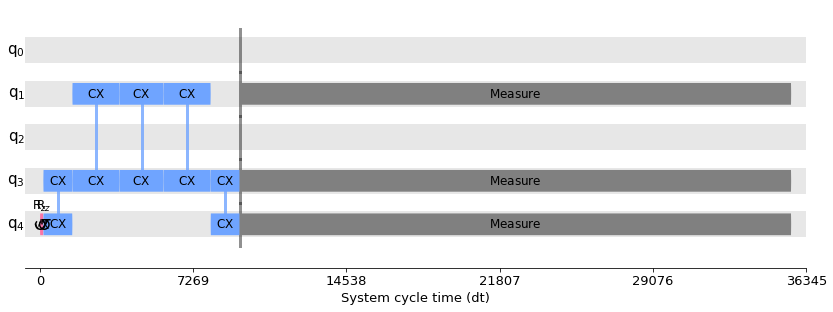

In [2]:
#Visualizing the scheduling of a circuit
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.visualization.timeline import draw
from qiskit.test.mock import FakeVigo #test on FakeVigo (5 qubit simulator)

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
# qc = QuantumCircuit(3)
# qc.h(0)
# qc.cx(0,1)
# qc.x(1)
# qc.cx(1,2)
# qc.h(2)
# qc.cx(2, 0)
# qc.x(2)
# qc.measure_all()

backend = FakeVigo() #FakeParis
qc = transpile(qc, backend, scheduling_method='alap')
draw(qc)

In [3]:
qc.draw(fold=-1)

┌─────────────────┐                                                                       ░ ┌──────────────────┐      
ancilla_0 -> 0 ┤ DELAY(9472[dt]) ├───────────────────────────────────────────────────────────────────────░─┤ DELAY(26160[dt]) ├──────
               ├─────────────────┤                                         ┌───┐     ┌─────────────────┐ ░ └──────────────────┘┌─┐   
      q_2 -> 1 ┤ DELAY(1536[dt]) ├───────────────────────────────■─────────┤ X ├──■──┤ DELAY(1376[dt]) ├─░─────────────────────┤M├───
               ├─────────────────┤                               │         └─┬─┘  │  └─────────────────┘ ░ ┌──────────────────┐└╥┘   
ancilla_1 -> 2 ┤ DELAY(9472[dt]) ├───────────────────────────────┼───────────┼────┼──────────────────────░─┤ DELAY(26160[dt]) ├─╫────
               └┬────────────────┤                 ┌───┐       ┌─┴─┐         │  ┌─┴─┐       ┌───┐        ░ └──────────────────┘ ║ ┌─┐
      q_1 -> 3 ─┤ DELAY(160[dt]) ├─────────────────┤ X ├───────┤ X ├─────────■──┤ X ├───────┤ X ├────────░──────────────────────╫─┤M├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘┌──────┴───┴──────┐     └───┘       └─┬─┘        ░         ┌─┐          ║ └╥┘
      q_0 -> 4 ────┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├──■──┤ DELAY(6560[dt]) ├───────────────────■──────────░─────────┤M├──────────╫──╫─
                   └─────────┘    └────┘└─────────┘     └─────────────────┘                              ░         └╥┘          ║  ║ 
       meas: 3/═════════════════════════════════════════════════════════════════════════════════════════════════════╩═══════════╩══╩═
                                                                                                                    0           1  2

In [4]:
result_normal = backend.run([qc]).result()
result_normal.get_counts(0)

{'110': 28,
 '001': 18,
 '100': 5,
 '011': 18,
 '111': 444,
 '101': 25,
 '010': 6,
 '000': 480}

Now construct a pass manager and run the predefined pass CrossTalkDelayReplace on the qc2 circuit.

In [5]:
from qiskit.transpiler import PassManager

pm = PassManager()
pm.append([CrossTalkDelayReplace(backend.configuration().coupling_map)])
# print(backend.configuration().coupling_map)

out_qc2 = pm.run(qc)
out_qc2.draw(fold=-1)

┌────────────────┐          ┌─────────────────┐                                                                    ┌─────────────────┐┌─────────────────┐                                                                          ░ ┌──────────────────┐      
   q_0: ┤ DELAY(160[dt]) ├─■────────┤ DELAY(1376[dt]) ├───────────────────────────────────────────────────────■────────────┤ DELAY(6560[dt]) ├┤ DELAY(1376[dt]) ├──────────────────────────────────────────────────────■───────────────────░─┤ DELAY(26160[dt]) ├──────
        ├────────────────┤ │ZZ(0.1) └─────────────────┘                              ┌─────────────────┐      │ZZ(0.1)     └─────────────────┘└─────────────────┘                        ┌───┐     ┌─────────────────┐ │ZZ(0.1)            ░ └──────────────────┘┌─┐   
   q_1: ┤ DELAY(160[dt]) ├─■──────────────■─────────────────────────────────■────────┤ DELAY(1376[dt]) ├──────■──────────────────■─────────────────────────────────■─────────────────────┤ X ├──■──┤ DELAY(1376[dt]) ├─■─────────■─────────░─────────────────────┤M├───
        ├────────────────┤                │ZZ(0.1)     ┌─────────────────┐│ │       │└─────────────────┘                         │ZZ(0.1)     ┌─────────────────┐  │  ┌─────────────────┐└─┬─┘  │  └─────────────────┘           │ZZ(0.1)  ░ ┌──────────────────┐└╥┘   
   q_2: ┤ DELAY(160[dt]) ├────────────────■────────────┤ DELAY(1376[dt]) ├┤  rzz_ct ├────────────────────────────────────────────■────────────┤ DELAY(6560[dt]) ├──┼──┤ DELAY(1376[dt]) ├──┼────┼────────────────────────────────■─────────░─┤ DELAY(26160[dt]) ├─╫────
        ├────────────────┤                             └─────────────────┘│ │ZZ(0.1)│       ┌───┐                                             └─────────────────┘┌─┴─┐└─────────────────┘  │  ┌─┴─┐       ┌───┐                            ░ └──────────────────┘ ║ ┌─┐
   q_3: ┤ DELAY(160[dt]) ├────────────────────────────────────────────────┼─■───────┼───────┤ X ├────────────────────────────────────────────────────────────────┤ X ├─────────────────────■──┤ X ├───────┤ X ├────────────────────────────░──────────────────────╫─┤M├
        └──┬─────────┬───┘  ┌────┐      ┌─────────┐                       │         │       └─┬─┘       ┌─────────────────┐                                      └───┘                        └───┘       └─┬─┘                            ░         ┌─┐          ║ └╥┘
   q_4: ───┤ RZ(π/2) ├──────┤ √X ├──────┤ RZ(π/2) ├───────────────────────┼─────────┼─────────■─────────┤ DELAY(6560[dt]) ├─────────────────────────────────────────────────────────────────────────────────■──────────────────────────────░─────────┤M├──────────╫──╫─
           └─────────┘      └────┘      └─────────┘                       │         │                   └─────────────────┘                                                                                                                ░         └╥┘          ║  ║ 
meas: 3/══════════════════════════════════════════════════════════════════╪═════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═══════════╩══╩═
                                                                          │         │                                                                                                                                                                 0           1  2

In [6]:
# Run using normal backend
result = backend.run([out_qc2]).result()
##Note: if the circuit is sufficiently complicated, you should see a majority of correct counts
## plus a few scattered incorrect (error) counts
result.get_counts(0)

{'101': 28,
 '100': 9,
 '001': 17,
 '110': 29,
 '010': 10,
 '000': 499,
 '011': 20,
 '111': 412}

In [15]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZZGate
import qiskit.quantum_info as qi
from qiskit.test.mock import FakeVigo

def test_circuit(coupling_map, theta=0, add_noise=False, delay=10):
    nq = np.max(coupling_map) + 1
    qc = QuantumCircuit(nq)
    qc.h(range(nq))
    qc.barrier(range(nq))
    qc.delay(delay, range(nq))
    if add_noise and coupling_map:
        finished = [] #coupling map has i, j and j, i
        for i, j in coupling_map:
            if [i, j] not in finished:
                qc.rzz(theta, i, j)
                finished.append([i, j])
                finished.append([j, i])
    qc.barrier(range(nq))
    qc.h(range(nq))
    return qc

def test_state(coupling_map, theta=0, add_noise=False):
    qc = test_circuit(coupling_map, theta, add_noise)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

def test_crosstalk_circuit(backend, theta=0.1):
    coupling_map = backend.configuration().coupling_map
    
    qc = test_circuit(coupling_map=coupling_map, delay=1000)
    qc = transpile(qc, backend, scheduling_method='alap')
    
    pm = PassManager()
    pm.append([CrossTalkDelayReplace(coupling_map, theta)])

    qc = pm.run(qc)
    return qc

def test_crosstalk_state(backend, theta=0.1):
    qc = test_crosstalk_circuit(backend, theta)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

test_circuit(coupling_map=FakeVigo().configuration().coupling_map, theta=0.1, add_noise=True).draw(fold=-1)

┌───┐ ░ ┌───────────────┐                                         ░ ┌───┐
q_0: ┤ H ├─░─┤ DELAY(10[dt]) ├─■───────────────────────────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤ │ZZ(0.1)                                ░ ├───┤
q_1: ┤ H ├─░─┤ DELAY(10[dt]) ├─■─────────■─────────■───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤           │ZZ(0.1)  │                   ░ ├───┤
q_2: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────■─────────┼───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                     │ZZ(0.1)            ░ ├───┤
q_3: ┤ H ├─░─┤ DELAY(10[dt]) ├─────────────────────■─────────■─────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                               │ZZ(0.1)  ░ ├───┤
q_4: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────────────────────────■─────────░─┤ H ├
     └───┘ ░ └───────────────┘                                         ░ └───┘

In [17]:
test_crosstalk_circuit(backend=FakeVigo()).draw(fold=-1)

┌─────────┐┌────┐┌─────────┐ ░ ┌─────────────────┐                                          ░ ┌─────────┐┌────┐┌─────────┐
q_0: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├─■────────────────────────────────────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤ │ZZ(0.1)                                 ░ ├─────────┤├────┤├─────────┤
q_1: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├─■─────────■──────────■───────────────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤           │ZZ(0.1) │ │       │           ░ ├─────────┤├────┤├─────────┤
q_2: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├───────────■────────┤  rzz_ct ├───────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤                    │ │ZZ(0.1)│           ░ ├─────────┤├────┤├─────────┤
q_3: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├────────────────────┼─■───────┼─■─────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤                    │         │ │ZZ(0.1)  ░ ├─────────┤├────┤├─────────┤
q_4: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├────────────────────┼─────────┼─■─────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     └─────────┘└────┘└─────────┘ ░ └─────────────────┘                    │         │           ░ └─────────┘└────┘└─────────┘

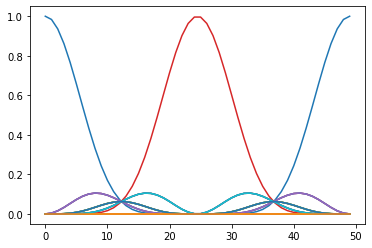

In [18]:
import matplotlib.pyplot as plt

backend = FakeVigo()
coupling_map = backend.configuration().coupling_map
states = [test_state(coupling_map, theta, True) for theta in np.linspace(0, 2 * np.pi, 50)]
probs = np.array([psi.probabilities() for psi in states]).T
for p in probs:
    plt.plot(p)

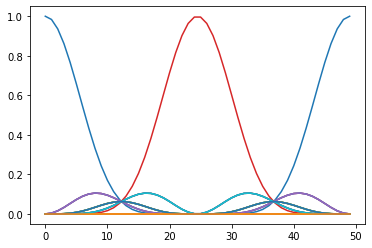

In [19]:
states_crosstalk = [test_crosstalk_state(backend, theta) for theta in np.linspace(0, 2 * np.pi, 50)]
probs_crosstalk = np.array([psi.probabilities() for psi in states_crosstalk]).T
for p in probs_crosstalk:
    plt.plot(p)